# Local Classifier 2 Sample Tests (C2ST) for conditional Normalizing Flows 


## Context & Objective
We consider a **conditional target density** $p(\theta \mid x)$ and **samples from the joint p.d.f** $\{\theta_i, x_i\} \sim p(\theta, x)$.

Our estimator is a **conditional Normalizing Flow** $q_{\phi}$ with base distribution $p(z) = \mathcal{N}(0,\mathbf{1}_m)$ and bijective transormation $T_{\phi}(.; x)$ defined on $\mathbb{R}^m$ and for all $x \in \mathbb{R}^d$.
    
- Its density can be explicilty evaluated using the inverse transformation:
    $$
    \forall \theta \in \mathbb{R}^m, \quad q_{\phi}(\theta \mid x) = p_{\mathcal{N}(0,\mathbf{1}_m)}(T_{\phi}^{-1}(\theta; x))\left|\operatorname{det} J_{T_{\phi}^{-1}}(\theta; x)\right|
    $$
    which means that flow can be trained via MLE on $N_1$ samples from the joint: 
$$\{\theta_i, x_i\}_{i=1}^{N_1} \sim p(\theta, x) \quad \rightarrow \quad \min_{\phi} -\frac{1}{N_1}\sum_{i=1}^N \log[q_{\phi}(\theta_i \mid x_i)] = -\frac{1}{N_1}\sum_{i=1}^N \log[p_{\mathcal{N}(0,\mathbf{1}_m)}(T_{\phi}^{-1}(\theta_i; x_i))\left|\operatorname{det} J_{T_{\phi}^{-1}}(\theta_i; x_i)\right|]$$

- We can sample from it using the forward transformation:
    $$z_i\sim p(z) = \mathcal{N}(0,\mathbf{1}_m) \quad \rightarrow \quad \theta^{\phi; x}_i = T_{\phi}(z_i; x)\sim q_{\phi}(\theta \mid x)$$
**GOAL:** Evaluate the ***local consistency of our estimator***, i.e. whether the following local null hypothesis holds for a fixed $x \in \mathbb{R}^d$
$$\mathcal{H}_0(x): p(\theta \mid x) = q_{\phi}(\theta \mid x), \quad \forall \theta \in \mathbb{R}^m$$



## Methodology 
**THEOREM: Local Consistency for NFs.** 
The local null hypothesis holds if, and only if, the inverse flow transformation applied to the target distribution recovers the base distribution. 

Using the same definition for $q_{\phi}$ as during sampling, $q_{\phi}(\theta \mid x) = p(T_{\phi}(z; x))$ (c.f. $T_{\phi}(z; x) \sim q_{\phi}(\theta \mid x)$ for $z\sim p(z)$), we have:
$$ p(\theta \mid x) = q_{\phi}(\theta \mid x) \iff p(T_{\phi}^{-1}(\theta; x)\mid x) = p(T_{\phi}^{-1}(T_{\phi}(z; x); x)) = p(z) = \mathcal{N}(0,\mathbf{1}_m)$$

**METHOD: Local C2ST.** 
We have a calibration dataset with $N_2$ samples from the joint $\{\theta_i, x_i\}_{i=1}^{N_2}$ (different than the data used to train the flow!)
1. Compute inverse flow-transformation: $T^{-1}_{\phi}(\theta_i,x_i)$

2. **Train classifier** to discriminate between the joint distributions $p(T^{-1}_{\phi}(\theta,x),x) = p(T^{-1}_{\phi}(\theta,x)\mid x)p(x)$ and $\mathcal{N}(0,1)p(x)$. This is a binary classification problem with 
    - **features** $[Z_i, x_i]$
    - **labels**: $Y = 0$, if $Z_i \sim \mathcal{N}(0,\mathbf{1}_m)$, $\quad Y=1$, if $Z_i = T^{-1}_{\phi}(\theta_i, x_i)$
    
3. **Evaluate consistency** for a given $x_0$, i.e. test whether $\mathcal{H}_0(x_0)$ holds: 
    
    - We evaluate the distribution of the predictive probability of belonging to class $0$ (normal distribution) $\hat{p}(Y=0\mid z,x_0)$ for $z\sim \mathcal{N}(0,\mathbf{1}_m)$ and fixed $x=x_0$: 
        - draw $z_i \sim \mathcal{N}(0,\mathbf{1}_m), i \in [1,N]$, 
        - evaluate the predictive probability of the trained classifier in the features $[z_i, x_0]$ (e.g. with the function `predict_proba` for `scikit-learn`-classifiers), 
        - ouput: a vector of samples $[\hat{p}(Y=0\mid z_1,x_0), \dots, \hat{p}(Y=0\mid z_N,x_0)]$ from the wanted distribution.
    
    - Under $\mathcal{H}_0(x_0)$, the discriminator should be completely uncertain about the predictive class, i.e. the predtictive probability should always be $0.5$, i.e. the distribution of the predictive probability (at $x_0$) should be a **dirac around $0.5$** (will be larger if not enough training samples, as unlikely datapoints that would not be covered by the training dataset could be considered out-of-distribution). 
    - Visualization:
        - histograms
        - PP-plots: c.d.f of the predicted probas vs. c.d.f of the dirac (step function)
    - Test statistics: 
        - total variation distance (TV_dist): euclidean distance between c.d.fs of predicted probas and dirac (step function)
        - wasserstein distance (w_dist) between dirac and predicted probas 

**Questions:**
- mathematical proof of the necessary and sufficient condition of the c2st test? 
- how to interpret the pp-plots of the predicted probabilities: what deviances from dirac indicate bias/dispersion? 

## Numerical illustration in 1D

In [1]:
# import libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os

import sys
sys.path.remove('/data/parietal/store/work/jlinhart/git_repos/HNPE')
sys.path.append('../../valDiags_flows/')

### Target density and Data Generation: 
Our target density is a 1D conditional gaussian ($m=1, d=2$):
$$p(\theta\mid x) = \mathcal{N}(x_1+x_2, 1), \quad x = (x_1, x_2) \sim \mathcal{N}(\mu, \Sigma)$$
where $\mu = [0, 0]$ and $\Sigma = \begin{pmatrix} 1 & 0.8\\ 0.8 & 1 \end{pmatrix}$.

This toy example is taken from [Zhao et al. (2021)].
Here, the "true" target distribution is exactly known: for any fixed $x_0 \in \mathbb{R}^2$ we can directly get samples $\theta_{x_0} \sim p(\theta \mid x_0) = \mathcal{N}(x_{0,1} + x_{0,2}, 1)$. Note however, that this is only used as a ground-truth reference: the density estimators (resp. validation metrics) are still being trained (resp. computed) on a dataset from the joint $\{\theta, x\} \sim p(\theta, x)$.

We chose this example to directly analyse the sensibility of validation diagnostics of conditional density estimators w.r.t. the context variable $x$, without any other influences on the result (e.g. introduced by the prior in SBI-context). 

Indeed, conditional density estimators can be valid on average over the $x$-space (global consistency), but be a bad approximators of the target distribution $p(\theta \mid x_0)$ at a specific location $x_0$ (local consistency). As done by [Zhao et al. (2021)] with the PIT, we will show that the vanilla C2ST, which only allows to measure global consistency, is invariant to covariate transforms in the $x$-space, whereas the proposed method ***local C2ST*** allows to detect the resulting local inconsistencies.

*Comment: this toy example is chosen outside of the SBI context* 
- *the simulator parameters $(\mu, \Sigma)$ are not what we want to estimate, i.e. the target variable $\theta$,*
- *there is no prior on the parameters $\theta$,*
- *the target distribution is not a posterior, just a "normal" conditional density (defined as a function of $x$)*

In [2]:
from data.data_generators import ConditionalGaussian1d

# Define Data Generator: 1D conditional gaussian
data_gen = ConditionalGaussian1d(mu=[0,0], sigma=[1,1], rho=0.8)

# Get train, cal and test datasets:
# - train samples are used to train the flow,
# - cal samples are used to learn the (unknown) PIT-distributions
# - test samples are used to evaluate the known and learned PIT-distributions 

train_size = 10_000  
cal_size = 5_000  
test_size = 1_000  

filename = '../saved_experiments/Gaussian1d/datasets.pkl'
if os.path.exists(filename):
    dataset = torch.load(filename)
    x_train, theta_train = dataset['train']
    x_cal, theta_cal = dataset['cal']
    x_test, theta_test = dataset['test']
else:
    x_train, theta_train = data_gen.get_joint_data(n=train_size)
    x_cal, theta_cal = data_gen.get_joint_data(n=cal_size)
    x_test, theta_test = data_gen.get_joint_data(n=test_size)
    dataset = {'train': [x_train, theta_train], 'cal': [x_cal, theta_cal], 'test': [x_test, theta_test]}
    torch.save(dataset, filename)

print("NB training samples: ", x_train.shape)
print("NB calibration samples: ", x_cal.shape)
print("NB test samples: ", x_test.shape)

NB training samples:  torch.Size([10000, 2])
NB calibration samples:  torch.Size([5000, 2])
NB test samples:  torch.Size([1000, 2])


In [3]:
from lampe.data import JointLoader
from lampe.inference import NPE, NPELoss
import torch
import torch.optim as optim
from lampe.utils import GDStep
from itertools import islice
from tqdm import tqdm


prior = data_gen.x_dist
simulator = data_gen.sample_theta

### Density Estimation
We consider two NF-estimators:
- good MAF: trained on the full context variable $X=(X_1, X_2)$
- bad MAF: trained on a non-sufficient context $g(X)=X_1$

We will see that the global consistency check (on average over $x$-space, and not locally at a specific location $x=x_0$) is insensitive to the covariate transforms in $x$-space: Both estimators pass the test. 

The local consistency test however will show that the bad MAF is actually not a good approximation of the target density when evaluated at some fixed location $x=x_0$.

In [5]:
from nde.train import train_lampe_npe
from data.feature_transforms import first_dim_only

maf_good = NPE(1, 2, transforms=5, hidden_features=[50])
best_val_loss, nb_epochs = train_lampe_npe(
        maf_good,
        theta_train,
        x_train,  # X=(X_1,X_2)
        num_epochs=100,
        batch_size=100,
        lr=1e-3,
        optimizer=torch.optim.AdamW,
        validation=True,
        epochs_until_converge=20,
    )

maf_bad = NPE(1, 1, transforms=5, hidden_features=[50])
best_val_loss_bad, nb_epochs = train_lampe_npe(
        maf_bad,
        theta_train,
        first_dim_only(x_train),  # X=(X_1,X_2)
        num_epochs=100,
        batch_size=100,
        lr=1e-3,
        optimizer=torch.optim.AdamW,
        validation=True,
        epochs_until_converge=20,
    )

 55%|█████▌    | 55/100 [00:22<00:18,  2.50epoch/s, loss=1.57]


### Evaluation of the trained flows using C2ST 
We use the `MLPClassifier` from `sklearn` with kwargs as specified in `sbi.utils.metrics` and 5000 calibration samples from the joint (this choice is motivated in the last section).

In [5]:
maf_good.eval()
maf_bad.eval()

# Compute the inverse flow transformation on samples from the calibration set 
inv_flow_samples_cal_good = maf_good.flow(x_cal).transform(theta_cal).detach().numpy()
inv_flow_samples_cal_bad = maf_bad.flow(first_dim_only(x_cal)).transform(theta_cal).detach().numpy()

# Generate data from the base / normal distribution 
from scipy.stats import norm
norm_samples = norm().rvs(cal_size)


#### 1. Global Consistency Check
We start by looking at the overall performance of our estimators: c2st score (i.e. cross-val accuracy) for a discrimination task between the inverse-flow distribution $p(T^{-1}_{\phi}(\theta; x))$ over the joint, and $\mathcal{N}(0,1)$. This gives us the expected performance over the $x$-space, and not for a specific location $x_0$. 

In [6]:
# Global test with mlp
from sbi.utils.metrics import c2st_scores
scores_good = c2st_scores(torch.tensor(inv_flow_samples_cal_good), torch.tensor(norm_samples[:,None]), n_folds=10)
scores_bad = c2st_scores(torch.tensor(inv_flow_samples_cal_bad), torch.tensor(norm_samples[:,None]), n_folds=10)
print('good:', np.mean(scores_good).__round__(2), '+/-', np.std(scores_good).__round__(2))
print('bad:', np.mean(scores_bad).__round__(2), '+/-', np.std(scores_bad).__round__(2))

good: 0.5 +/- 0.01
bad: 0.49 +/- 0.02


Both estimators (good and bad) show good average performance! 

As a reference we show the global PIT distribution as in [Zhao et al. (2021)]:

In [7]:
from data.feature_transforms import first_dim_only, identity
import torch.distributions as D

def cdf_flow_lampe(target, context, flow, base_dist=D.Normal(0,1)):
    return base_dist.cdf(flow(context).transform(target))

def cde_pit_values_lampe(
    target, context, flow
):
    pit_values = (
        cdf_flow_lampe(target, context, flow)
        .detach()
        .numpy()
    )
    return pit_values

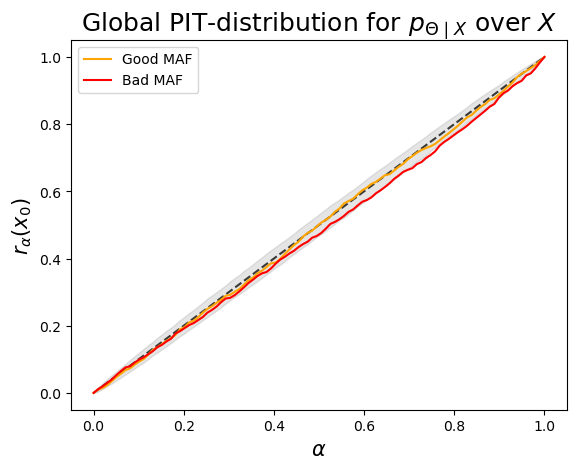

In [8]:
# PLOT GLOBAL/EXPECTED PIT-DISTRIBUTION of the trained estimators
from diagnostics.pp_plots import PP_plot_1D
from data.feature_transforms import first_dim_only

# Compute PIT-values of the flows F_{Q|X_i}(Theta_i)
# [PIT(Theta_i, X_i, maf_good) = F_{Q_good|X_i}(Theta_i)]
flow_joint_pit_values_good = cde_pit_values_lampe(
    theta_test, x_test, maf_good.flow
)
# [PIT(Theta_i, X_i, maf_bad) = F_{Q_bad|X_i}(Theta_i)]
flow_joint_pit_values_bad = cde_pit_values_lampe(

    theta_test, first_dim_only(x_test), maf_bad.flow
)

# PP-plot of global PIT-distribution for both flows
# alpha-quantiles = [P_X,Theta(Z < alpha)]
alphas = np.linspace(0,1,100)
PP_plot_1D(
    PIT_values=[flow_joint_pit_values_good, flow_joint_pit_values_bad],
    alphas=alphas,
    colors=["orange", "red"],
    labels=["Good MAF", "Bad MAF"],
    title=r"Global PIT-distribution for $p_{\Theta \mid X}$ over $X$",
    confidence_int=True,
)

#### 2. Local Consistency
We evaluate the true target density and the trained estimators in $x_0 = [0,1]$.

#### True and estimated densities at $x_0$

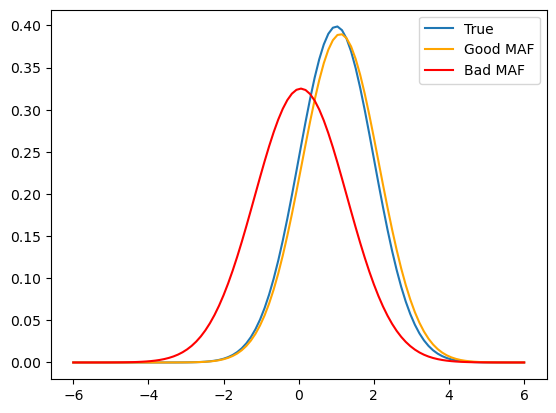

In [10]:
# Samples from the conditional distribution Theta|X=x_0
x_0 = torch.FloatTensor([[0, 1]])

samples_theta_x = torch.FloatTensor(
    [data_gen.sample_theta(x_0) for i in range(len(x_cal))]
).reshape(-1, 1)

# Plot PDF of trained flows evaluated in x_0
flows = {"Good MAF": (maf_good.flow, x_0, "orange"), "Bad MAF": (maf_bad.flow, x_0[:, 0], "red")}
grid = torch.linspace(-6,6,100).reshape(-1,1)
plt.plot(grid.numpy(), norm(loc=1,scale=1).pdf(grid.numpy()), label='True')
plt.plot(grid.numpy(), maf_good.flow(x_0).log_prob(grid).detach().exp(), color='orange', label='Good MAF')
plt.plot(grid.numpy(), maf_bad.flow(first_dim_only(x_0)).log_prob(grid).detach().exp(), color='red', label='Bad MAF')
plt.legend()
plt.show()


- bad maf: negative bias and a little overdispersed
- good maf: seems fine, just a little positive bias.

This is can also be seen in the local PIT distribution that we can compute as a reference using the samples from the "true" target density at $x_0$, $p(\theta \mid x_0)$:

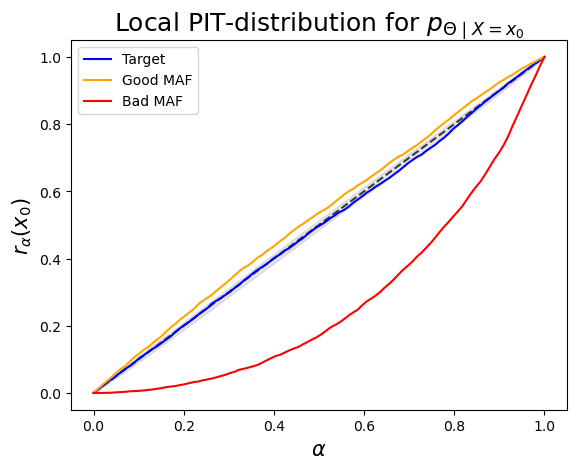

In [11]:
# Local PIT-distribution on samples Theta_{0,i} ~ Theta|X=x_0

# Compute PIT-values [PIT(Theta_{0,i}, X=x_0, p_true/good/bad) = F_{true/good/bad|x_0}(Theta_{0,i})]
true_local_pit_values = data_gen.true_pit_values(samples_theta_x, x_0, local=True)
flow_local_pit_values_good = cde_pit_values_lampe(
    samples_theta_x, x_0.repeat(5000,1), flow=maf_good.flow, 
)
flow_local_pit_values_bad = cde_pit_values_lampe(
    samples_theta_x, first_dim_only(x_0.repeat(5000,1)), flow=maf_bad.flow, 
)

# PP-plot of the local distribution
# alpha-quantiles = [P_{Theta|X}(Z < alpha)]
PP_plot_1D(
    PIT_values=[
        true_local_pit_values,
        flow_local_pit_values_good,
        flow_local_pit_values_bad,
    ],
    alphas=alphas,
    colors=["blue", "orange", "red"],
    labels=["Target", "Good MAF", "Bad MAF"],
    title=r"Local PIT-distribution for $p_{\Theta \mid X=x_0}$",
    confidence_int=True,
)

#### Local C2ST at $x_0$

##### Predict probas at $x_0$ 

You can run the following cell to obtain results directly for a certain number of trials by specifying `n_trials`...

In [12]:
# train classifier and predict probas for x_0
from diagnostics.localC2ST import local_flow_c2st, eval_local_flow_c2st
from scipy.stats import multivariate_normal as mvn

n_trials = 10
clfs_good = []
clfs_bad = []
clfs_null = []
probas_good = []
probas_bad = []
probas_null = []
z_values = mvn(mean=np.zeros(1), cov=np.eye(1)).rvs(5000)

for t in range(n_trials): 
        # good and bad maf 
        # train classifiers 
        clfs_good.append(local_flow_c2st(inv_flow_samples_cal_good, x_cal))
        clfs_bad.append(local_flow_c2st(inv_flow_samples_cal_bad, x_cal))
        # predict probas 
        probas_good.append(eval_local_flow_c2st(clfs_good[t], x_0[0], dim=1, size=5000, z_values=z_values)[0])
        probas_bad.append(eval_local_flow_c2st(clfs_bad[t], x_0[0], dim=1, size=5000, z_values=z_values)[0])
        # null hypothesis
        # train classifier
        clfs_null.append(local_flow_c2st(norm_samples[:,None], x_cal))
        # predict probas
        probas_null.append(eval_local_flow_c2st(clfs_null[t], x_0[0], dim=1, size=5000, z_values=z_values)[0])

##### Plot histograms 

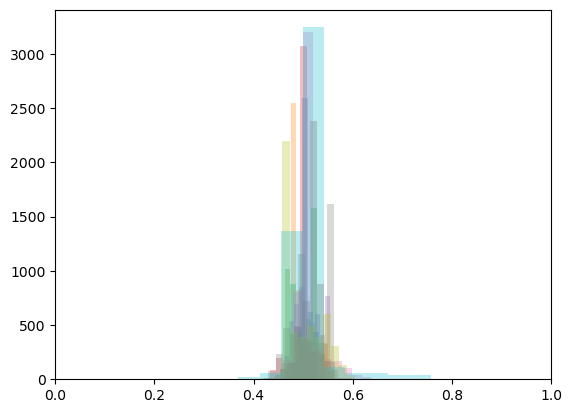

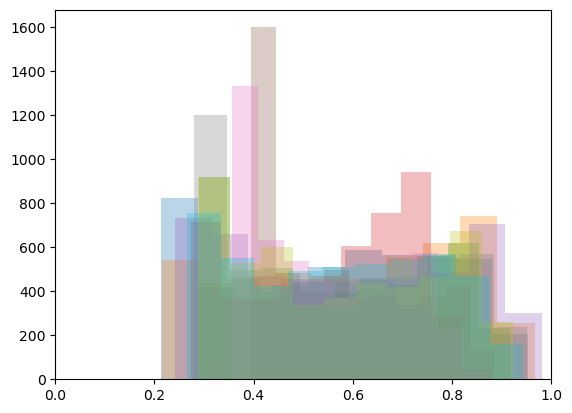

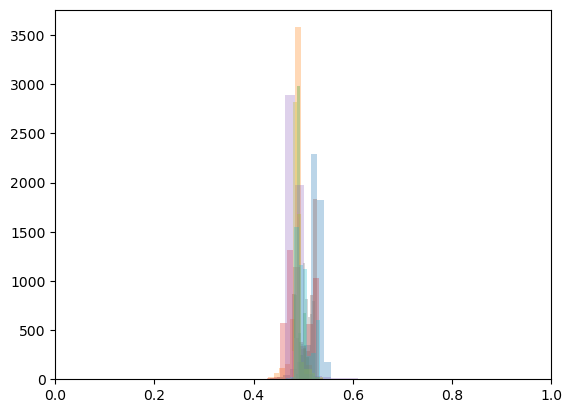

In [13]:
for t in range(n_trials):
    plt.hist(probas_good[t],alpha=0.3)
plt.xlim(0,1)
plt.show()

for t in range(n_trials):
    plt.hist(probas_bad[t],alpha=0.3)
plt.xlim(0,1)
plt.show()

for t in range(n_trials):
    plt.hist(probas_null[t],alpha=0.3)
plt.xlim(0,1)
plt.show()

##### Hyptothesis Test Diagnostics (evaluate w.r.t null-hypothesis)

1. Total variation (TV): distribution (c.d.f.) of predicted probas 

The associated test-statistic (TV_dist) is the euclidean distance to the c.d.f of the dirac function at $0.5$ (step function in black dashed line).

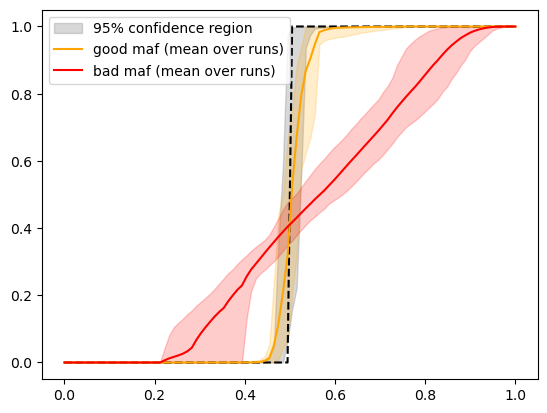

Test statistics and p-values for the mean run:

test stat good :  5.674183080000002e-03
p-value good :  0.8

test stat bad :  0.061504947431999996
p-value bad :  0.0


In [14]:
from diagnostics.pp_plots import PP_vals


alphas = np.linspace(0,1,100)
pp_vals_dirac = PP_vals([0.5]*5000, alphas)
plt.plot(alphas, pp_vals_dirac, '--', color='black')

pp_vals_null = {}
test_stats_null = {}
for t in range(len(probas_null)):
    pp_vals_null[t] = pd.Series(PP_vals(probas_null[t], alphas))
    test_stats_null[t] = ((pp_vals_null[t]- pp_vals_dirac) ** 2).sum() / len(alphas)

pp_vals_good = {}
pp_vals_bad = {}
test_stats_good = {}
test_stats_bad = {}
for t in range(len(probas_null)):
    pp_vals_good[t] = pd.Series(PP_vals(probas_good[t], alphas))
    pp_vals_bad[t] = pd.Series(PP_vals(probas_bad[t], alphas))
    test_stats_good[t] = ((pp_vals_good[t]- pp_vals_dirac) ** 2).sum() / len(alphas)
    test_stats_bad[t] = ((pp_vals_bad[t]- pp_vals_dirac) ** 2).sum() / len(alphas)

low_null = pd.DataFrame(pp_vals_null).quantile(0.05/2, axis=1)
up_null = pd.DataFrame(pp_vals_null).quantile(1-0.05/2, axis=1)
plt.fill_between(alphas, low_null, up_null, color="grey", alpha=0.3, label='95% confidence region')

low_good = pd.DataFrame(pp_vals_good).min(axis=1)
up_good = pd.DataFrame(pp_vals_good).max(axis=1)
mean_good = pd.DataFrame(pp_vals_good).mean(axis=1)
plt.plot(alphas, mean_good, label='good maf (mean over runs)', color='orange')
plt.fill_between(alphas, low_good, up_good, color="orange", alpha=0.2)

low_bad = pd.DataFrame(pp_vals_bad).min(axis=1)
up_bad = pd.DataFrame(pp_vals_bad).max(axis=1)
mean_bad = pd.DataFrame(pp_vals_bad).mean(axis=1)
plt.plot(alphas, mean_bad, label='bad maf (mean over runs)', color='red')
plt.fill_between(alphas, low_bad, up_bad, color="red", alpha=0.2)
plt.legend()
plt.show()


# Test statistics and p-values for the mean run
print('Test statistics and p-values for the mean run:')
print()
test_stat_good = ((mean_good - pp_vals_dirac) ** 2).sum() / len(alphas)
p_value_good = sum(1 * (test_stat_good < pd.Series(test_stats_null))) / len(test_stats_null)
print('test stat good : ', test_stat_good)
print('p-value good : ', p_value_good)
print()

test_stat_bad = ((mean_bad - pp_vals_dirac) ** 2).sum() / len(alphas)
p_value_bad = sum(1 * (test_stat_bad < pd.Series(test_stats_null))) / len(test_stats_null)
print('test stat bad : ', test_stat_bad)
print('p-value bad : ', p_value_bad)

2. Wasserstein distance (w_dist) between dirac and predicted probas for class 0

This metric was introduced because we found that in some cases (c.f. `JRNMM.ipynb`) where the confidence region is quite large the distance to the heaviside step function is maybe not the best: even under the null hypothesis values can get high (e.g. higher than for the uniform distribution that will thus not be rejected) as the discontinuity will yield several values will be at or close to the max distance of 1.

In [17]:
from scipy.stats import wasserstein_distance
w_dist_good = [wasserstein_distance([0.5]*5000, probas_good[t]) for t in range(10)]
w_dist_bad = [wasserstein_distance([0.5]*5000, probas_bad[t]) for t in range(10)]
w_dist_null = [wasserstein_distance([0.5]*5000, probas_null[t]) for t in range(10)]

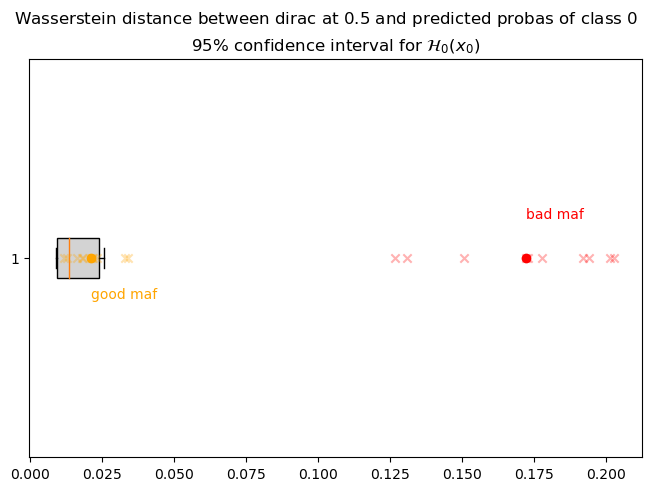

Test statistics and p-values for the mean run:

good maf:
test stat:  0.02107495960005735
p_value:  0.2
bad maf:
test stat:  0.17213487382548862
p_value:  0.0


In [18]:
import matplotlib.cbook as cbook

data = w_dist_null
stats = cbook.boxplot_stats(data)[0]
stats['q1'] = np.quantile(data, 0.05)
stats['q3'] = np.quantile(data, 0.95)
stats['whislo'] = min(data)
stats['whishi'] = max(data)

fig, ax = plt.subplots(1, 1, constrained_layout=True)
bp = ax.bxp([stats],widths=0.1, vert=False, showfliers=False, patch_artist=True)
bp['boxes'][0].set_facecolor('lightgray')

plt.text(np.mean(w_dist_good), 0.9, 'good maf', color='orange')
plt.scatter(np.mean(w_dist_good), 1, color='orange', zorder=10)
for a in w_dist_good:
    plt.scatter(a, 1, marker='x', color='orange', zorder=10, alpha=0.3)
plt.text(np.mean(w_dist_bad), 1.1, 'bad maf', color='red')
plt.scatter(np.mean(w_dist_bad), 1, color='red')
for a in w_dist_bad:
    plt.scatter(a, 1, marker='x', color='red', zorder=11, alpha=0.3)

p_value_good = sum(1 * (np.mean(w_dist_good) < pd.Series(w_dist_null))) / len(w_dist_null)
p_value_bad = sum(1 * (np.mean(w_dist_bad) < pd.Series(w_dist_null))) / len(w_dist_null)

# plt.legend()
plt.title(r'95% confidence interval for $\mathcal{H}_0(x_0)$')
plt.suptitle(r'Wasserstein distance between dirac at $0.5$ and predicted probas of class 0')
plt.show()
print('Test statistics and p-values for the mean run:')
print()
print('good maf:')
print('test stat: ', np.mean(w_dist_good))
print('p_value: ', p_value_good)
print('bad maf:')
print('test stat: ', np.mean(w_dist_bad))
print('p_value: ', p_value_bad)

#### Interpretability: where can the classifier discriminate (or not)?
(cf. [Lee et al. (2018)])

The distributions we which to compare with this local C2ST test are the $p(z \mid x_0)$ where $z = T_{\phi}^{-1}(\theta; x_0)$ or $z \sim \mathcal{N}(0,1)$
- the true distribution at $x_0$ of the inverse transformation at $x_0$ (for good and bad maf): $p(T_{\phi}^{-1}(\theta; x_0)\mid x_0)$
- the normal distribution $\mathcal{N}(0,1)$

Using the samples from the true conditional distribution $p(\theta \mid x_0)$ (which we only have in this toy example and not in a regular sbi setting), we can get samples from the inverse transformations and plot the histograms.

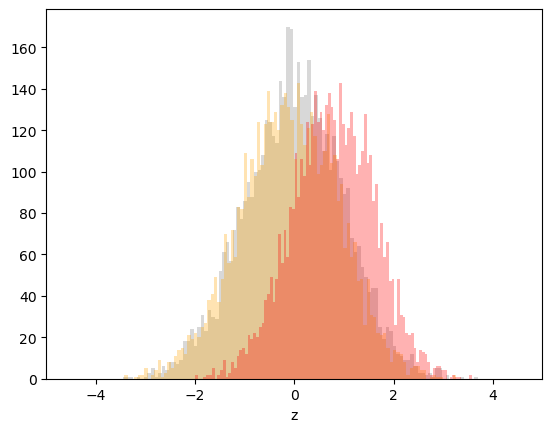

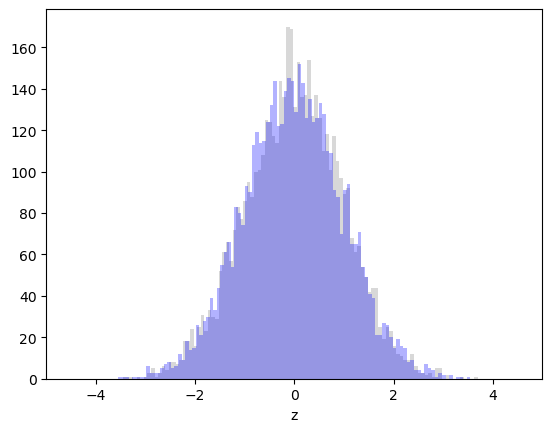

In [19]:
# Hist of the distributions: norm, inv-flow good/bad
inv_flow_samples_true_good = maf_good.flow(x_0).transform(samples_theta_x).detach().numpy()
inv_flow_samples_true_bad = maf_bad.flow(first_dim_only(x_0)).transform(samples_theta_x).detach().numpy()
plt.hist(z_values, bins=100, color='grey', alpha=0.3)
# plt.hist(norm_samples, bins=100, color='blue', alpha=0.3)
plt.hist(inv_flow_samples_true_good, bins=100, color='orange', alpha=0.3)
plt.hist(inv_flow_samples_true_bad, bins = 100, color='red', alpha=0.3)
plt.xlabel('z')
plt.xlim(-5,5)
plt.show()

plt.hist(z_values, bins=100, color='grey', alpha=0.3)
plt.hist(norm_samples, bins=100, color='blue', alpha=0.3)
plt.xlabel('z')
plt.xlim(-5,5)
plt.show()

This shows us what we should expect from our predicted probabilities: regions where the norm pdf (blue) nis higher than the other (orange or red), the predicted probas should be above 0.5, otherwise they should be below 0.5. 

It relates to the exact opposite case of what we saw in the pdf plot of the learned distributions at $x_0$: 
- negative bias becomes positive bias
- overdispersion becomes underdispersion

WHY? inverse transformation? always the case? just inverse affine transformation of the MAF...?


In [20]:
# train classifier and predict probas for x_0 over a grid
from diagnostics.localC2ST import local_flow_c2st, eval_local_flow_c2st

grid = np.linspace(-5,5,1000)

n_trials = 10
probas_grid_good = []
probas_grid_bad = []
probas_grid_null = []

for t in range(n_trials): 
        # predict probas 
        # good and bad maf
        probas_grid_good.append(eval_local_flow_c2st(clfs_good[t], x_0[0], dim=1, z_values=grid)[0])
        probas_grid_bad.append(eval_local_flow_c2st(clfs_bad[t], x_0[0], dim=1, z_values=grid)[0])

        # null hypothesis
        probas_grid_null.append(eval_local_flow_c2st(clfs_null[t], x_0[0], dim=1, z_values=grid)[0])


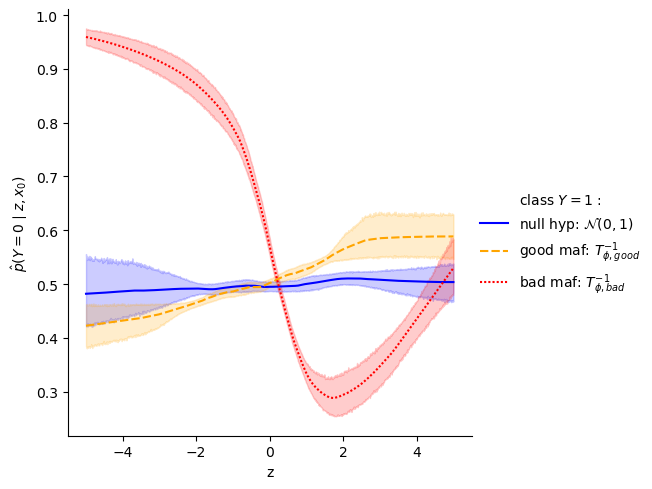

In [23]:
# plot predicted probas over grid
probas = np.concatenate(
    [
        np.concatenate(probas_grid_null),
        np.concatenate(probas_grid_good),
        np.concatenate(probas_grid_bad),
    ]
)
grids = np.concatenate([grid.reshape(-1,1)]*30)
names = [r'null hyp: $\mathcal{N}(0,1)$']*10000+[r'good maf: $T^{-1}_{\phi,good}$']*10000+[r'bad maf: $T^{-1}_{\phi,bad}$']*10000

df = pd.DataFrame({r'class $Y=1$ :': names, r'$\hat{p}(Y=0 \mid z,x_0)$': probas, 'z': grids[:,0]})

import seaborn as sns
sns.relplot(
        data=df, x="z", y=r"$\hat{p}(Y=0 \mid z,x_0)$",
        hue=r'class $Y=1$ :', style=r'class $Y=1$ :', kind="line", palette=['blue','orange','red']
    )
plt.show()

Results:
- red (bad): high probas (>0.5) until $z\approx0.5$ (which is where the norm pdf is indeed higher) and low probas (<0.5) between $z\approx 0.5$ and $z\approx2.5$ (which is where the red pdf is higher), then high probas again but at the border of the norm pdf support... (could indicate underdispersion)
- orange (good): pretty insignificant probas (around 0.5) a little drop at $z=0^-$, and higher probas at the borders of the norm pdf (again underdispersion..?)
- blue (norm/null): always around 0.5.

The location of the peak of the low-probas indicates positive/negative bias (in 1D at least). 

In higher dimensions we cannot talk/conclude about bias or over/underdispersion, but we can identify the regions where one or the other pdf in higher, and where they are equal. 

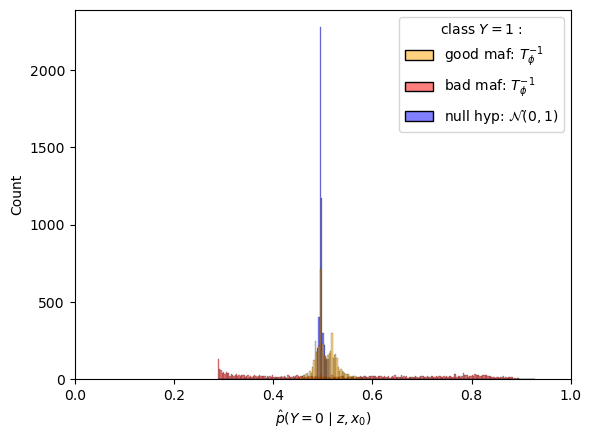

In [24]:
# plot predicted probas for x_0 no 0
probas_z = np.concatenate(
    [
        np.mean(probas_good, axis=0),
        np.mean(probas_bad, axis=0),
        np.mean(probas_null, axis=0),
    ]
)
# grids = np.concatenate([grid.reshape(-1,1)]*30)
names = [r'good maf: $T^{-1}_{\phi}$']*5000+[r'bad maf: $T^{-1}_{\phi}$']*5000+[r'null hyp: $\mathcal{N}(0,1)$']*5000

df = pd.DataFrame({r'class $Y=1$ :': names, r'$\hat{p}(Y=0 \mid z,x_0)$': probas_z})

import seaborn as sns
sns.histplot(
        data=df, x=r"$\hat{p}(Y=0 \mid z,x_0)$",
        hue=r'class $Y=1$ :',  palette=['orange','red','blue']
)
plt.xlim(0,1)
plt.show()

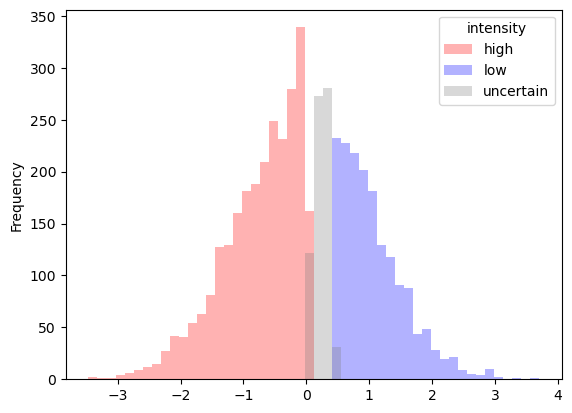

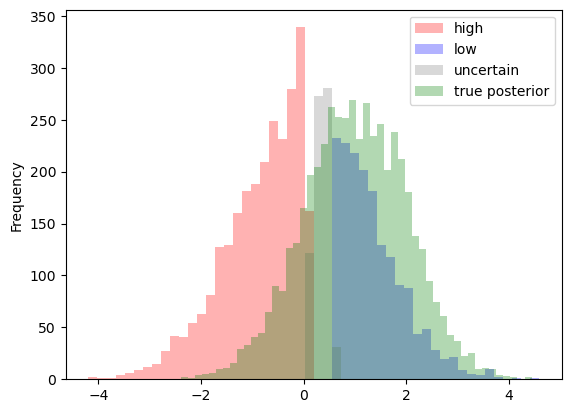

In [25]:
df_bad = pd.DataFrame({'z':z_values, 'probas': np.array(probas_bad).mean(axis=0)})
# df[df['probas']>0.55]
df_bad['intensity'] = ['uncertain']*len(df_bad)
df_bad.loc[df_bad['probas']>0.55, 'intensity'] = 'high'
df_bad.loc[df_bad['probas']<0.45, 'intensity'] = 'low'
df_bad.pivot(columns='intensity', values='z').plot.hist(bins=50, color=['red','blue','grey'], alpha=0.3)

fwd_flow = maf_bad.flow(first_dim_only(x_0)).transform.inv(torch.FloatTensor(z_values).reshape(-1,1)).detach().numpy()

df_bad['theta'] = fwd_flow
df_bad.pivot(columns='intensity', values='theta').plot.hist(bins=50, color=['red','blue','grey'], alpha=0.3)
plt.hist(samples_theta_x.numpy(), color='green', alpha=0.3, bins=50, label='true posterior')
plt.legend()
plt.show()

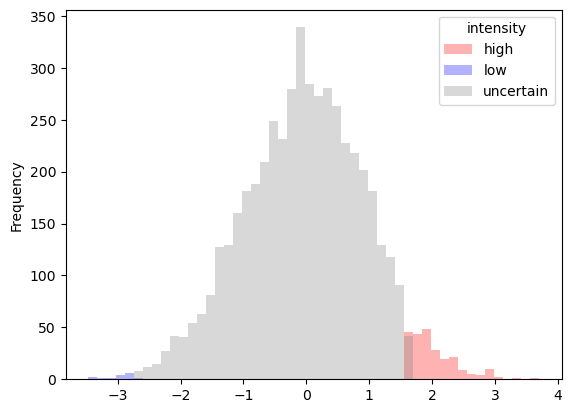

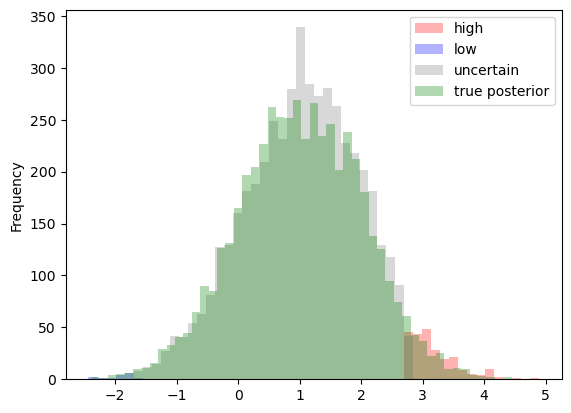

In [26]:
df_good = pd.DataFrame({'z':z_values, 'probas': np.array(probas_good).mean(axis=0)})
# df[df['probas']>0.55]
df_good['intensity'] = ['uncertain']*len(df_good)
df_good.loc[df_good['probas']>0.55, 'intensity'] = 'high'
df_good.loc[df_good['probas']<0.45, 'intensity'] = 'low'
df_good.pivot(columns='intensity', values='z').plot.hist(bins=50, color=['red','blue','grey'], alpha=0.3)
plt.show()

fwd_flow = maf_good.flow(x_0).transform.inv(torch.FloatTensor(z_values).reshape(-1,1)).detach().numpy()

df_good['theta'] = fwd_flow
df_good.pivot(columns='intensity', values='theta').plot.hist(bins=50, color=['red','blue','grey'], alpha=0.3)
plt.hist(samples_theta_x.numpy(), color='green', alpha=0.3, bins=50, label='true posterior')
plt.legend()
plt.show()